# Twitter Sentiment Analysis

**Useful links**

* Twitter Developers: https://developer.twitter.com/en/portal/dashboard

* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

* Find user name based on author_id: https://tweeterid.com/

* Similar use-case: https://github.com/julesz12345/Cryptocurrency-Prediction/blob/main/Code.ipynb

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})

import plotly.express as px

## Load data

In [2]:
# Load dataset

# datafile = "../data/twitter_data.csv"
# datafile = "../data/twitter_data_full.csv"
# datafile = "../data/twitter_data_hourly_full.csv"
datafile = "../data/numerai_twitter_api.csv"

tweets_df = pd.read_csv(datafile)

In [3]:
tweets_df = tweets_df.drop_duplicates()

In [4]:
# Check shape
tweets_df.shape

(24808, 8)

In [5]:
# Check dataset
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count
0,1141208687001780225,2021-08-30 23:46:47+00:00,1432490010046078977,$NMR\n🔻 Decreased 4.34% in 9.8 hour(s)\n💵 Pric...,0,0,0,0
1,1150271775273619456,2021-08-30 23:41:40+00:00,1432488721979527169,$BNT $CRV $NMR $OGN $REP $REQ $CVC $MLN keep a...,3,0,1,0
2,23025079,2021-08-30 23:21:26+00:00,1432483630341820421,$coti added some 33s 💁‍♂️🙈\n$btc $eth $mkr $aa...,4,1,14,1
3,1329640297760911361,2021-08-30 23:09:30+00:00,1432480627274629130,NO MONSTER NO GAIN!\n\nMarket analysis &amp; r...,0,0,0,0
4,2896209087,2021-08-30 22:52:57+00:00,1432476464742608906,$NMR decision time is coming soon. I see two p...,3,0,1,0


In [6]:
# Check dataset
tweets_df.tail()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count
24803,4721854075,2020-01-01 15:56:44+00:00,1212402283587276800,🕵️‍♂️ @numerai is this market cycle's Madoff,0,0,0,0
24804,276220644,2020-01-01 15:48:43+00:00,1212400264600313858,1/ $NMR marketcap is a joke rn ... but does th...,3,1,2,0
24805,898944887848153092,2020-01-01 14:01:27+00:00,1212373271464808449,#crypto price changes last hour\n\n🚀\n$TTC +23...,0,0,0,0
24806,929053205526298624,2020-01-01 12:27:56+00:00,1212349735811444738,1BTC --&gt; 30BTC JUST 1 MONTH\n\nJoin : https...,0,0,0,0
24807,929053205526298624,2020-01-01 04:27:54+00:00,1212228934592425984,0.05BTC --&gt; 20BTC We need Just a Week \n\nJ...,0,0,0,0


In [7]:
print("First date:", tweets_df["created_at"].min())
print("Last date:", tweets_df["created_at"].max())

First date: 2020-01-01 04:27:54+00:00
Last date: 2021-08-30 23:46:47+00:00


In [8]:
# Check Datatypes
tweets_df.dtypes

author_id         int64
created_at       object
tweet_id          int64
text             object
like_count        int64
quote_count       int64
reply_count       int64
retweet_count     int64
dtype: object

In [9]:
# Fix Data types
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], format ="%Y-%m-%d %H:%M:%S")

In [10]:
# Create new columns
tweets_df["created_at_date"] = tweets_df["created_at"].dt.date
tweets_df["created_at_date_hour"] = tweets_df["created_at"].dt.date.astype(str) + " " + tweets_df["created_at"].dt.hour.astype(str)

**Notes**

* The API respond data based on `created_at` timestamp. I can't query tweetes based on popularity using the Twitter API v2 (`result_type=popular` is not available).

## Add usernames

In [ ]:
import yaml
import requests
import json

def auth():
    with open("../config.yaml") as file:
        passwords = yaml.safe_load(file)
    return passwords["search_tweets_api"]["bearer_token"]

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r

def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth,)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

def create_url(author_id):
    url = f"https://api.twitter.com/2/users/{author_id}?&user.fields=created_at,verified,public_metrics"
    return url

In [ ]:
## DEV 
bearer_token = auth()
url = create_url(1334365558259679238)
json_response = connect_to_endpoint(url)
print(json.dumps(json_response, indent=4, sort_keys=True))

In [ ]:
## Create the authors_df with info about author_id

unique_authors = tweets_df["author_id"].unique()

authors_df = pd.DataFrame()

for author_id in tqdm(unique_authors):
    url = create_url(author_id)
    json_response = connect_to_endpoint(url)
    author_id_row = json_normalize(json_response['data'])
    authors_df = authors_df.append(author_id_row)

In [ ]:
# Pre-process dataset
authors_df = authors_df[['id', 'username', 'name', 'verified',
                        'public_metrics.followers_count', 'public_metrics.following_count',
                        'public_metrics.tweet_count', 'public_metrics.listed_count',
                        'created_at']]

authors_df = authors_df.rename(columns={"id":"author_id", "created_at":"user_created_at"})

authors_df["author_id"] = authors_df["author_id"].astype(int)

In [ ]:
authors_df.head()

In [ ]:
# Merge authors_df with tweets_df dataset
tweets_df = tweets_df.merge(authors_df, on = "author_id", how="left")

## EDA

In [11]:
# Check columns
tweets_df.columns

Index(['author_id', 'created_at', 'tweet_id', 'text', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'created_at_date',
       'created_at_date_hour'],
      dtype='object')

In [12]:
# What is the proportion of unique accounts
total_unique_accounts = tweets_df["author_id"].nunique()
print(f"There are {total_unique_accounts} unique accounts, on {len(tweets_df)} tweets ({np.round(total_unique_accounts/len(tweets_df),2)}%).")

There are 2953 unique accounts, on 24808 tweets (0.12%).


In [13]:
# Total number of tweets per Minute
print("Total number of tweets per Minute")
tweets_df["created_at"].dt.minute.value_counts().sort_index(ascending=False)

Total number of tweets per Minute


59     265
58     234
57     229
56     244
55     303
54     281
53     733
52     218
51     240
50     278
49     241
48     321
47     536
46     638
45     282
44     255
43     257
42     216
41     281
40     451
39     995
38     238
37     211
36     253
35     264
34     230
33     594
32    1119
31     772
30     360
29     255
28     244
27     708
26     224
25     308
24     247
23     271
22     255
21     246
20     267
19     246
18     307
17     529
16     599
15     382
14     253
13     269
12     280
11     317
10     571
9     1107
8      344
7      309
6      457
5      527
4      375
3      509
2      489
1     1063
0     1311
Name: created_at, dtype: int64

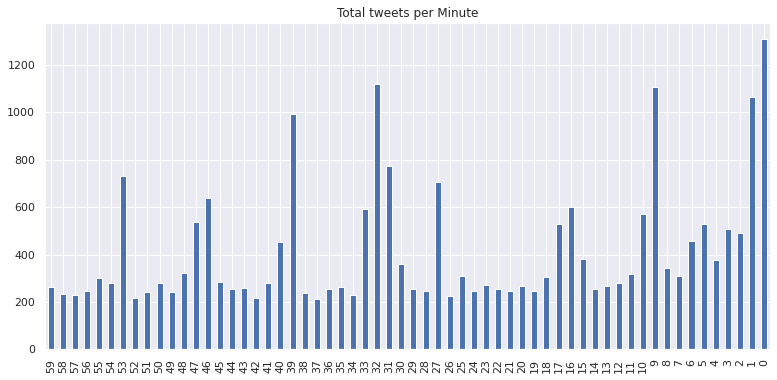

In [14]:
(tweets_df["created_at"]
 .dt.minute
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Minute"));

**Non-uniform distribution per hour**

I query ~300 tweets per hour, using the Twitter API v2,
based on a certain keywords and conditions.
This means that for every hour I gather the relevant tweets but with chronological order, not based on popularity. So, as one can see in the distribution, the vast majority of tweets lies in the later half of the hour and I don't have much information about the first half.


**Possible Work-arounds:**

* Query based on popularity and not chronologicaly (doesn't supported in Twitter API v2).
* write more specific queries to exclude irrelevant tweets
* Query tweets from specific accounts only
* Query all tweets

In [15]:
# Total number of tweets per Hour
print("Total number of tweets per Hour")
tweets_df["created_at"].dt.hour.value_counts().sort_index(ascending=True)

Total number of tweets per Hour


0      967
1      979
2      935
3      910
4      889
5      812
6      809
7      849
8      842
9      937
10    1024
11     986
12    1114
13    1054
14    1139
15    1253
16    1173
17    1212
18    1196
19    1337
20    1157
21    1011
22    1144
23    1079
Name: created_at, dtype: int64

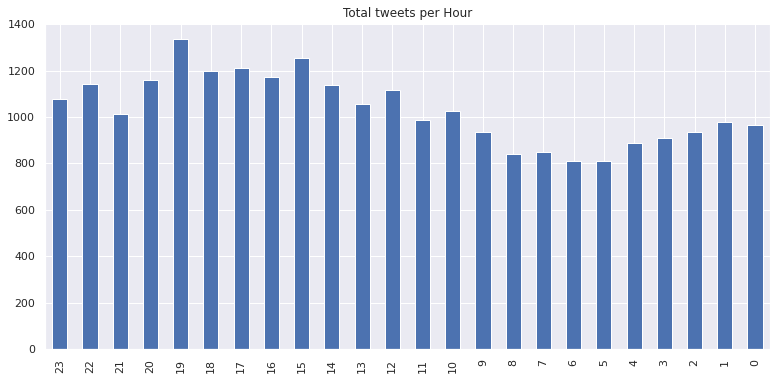

In [16]:
(tweets_df["created_at"]
 .dt.hour
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Hour"));

In [17]:
# Total number of tweets per Date
print("Total number of tweets per Date")
tweets_df["created_at"].dt.date.value_counts().sort_index()

Total number of tweets per Date


2020-01-01     7
2020-01-02     6
2020-01-03     8
2020-01-04     4
2020-01-05     3
              ..
2021-08-26    52
2021-08-27    37
2021-08-28    40
2021-08-29    31
2021-08-30    66
Name: created_at, Length: 608, dtype: int64

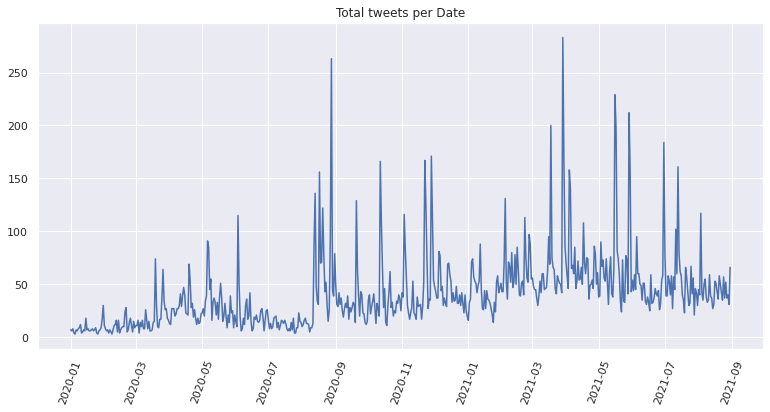

In [18]:
(tweets_df["created_at"]
 .dt.date
 .value_counts()
 .sort_index(ascending=True)
 .plot.line(title="Total tweets per Date", rot=70));

In [19]:
# Total number of tweets per Date
print("Total number of tweets per Month")
tweets_df["created_at"].dt.month.value_counts().sort_index()

Total number of tweets per Month


1     1557
2     2076
3     2755
4     2860
5     3276
6     2173
7     2018
8     3021
9      984
10    1190
11    1596
12    1302
Name: created_at, dtype: int64

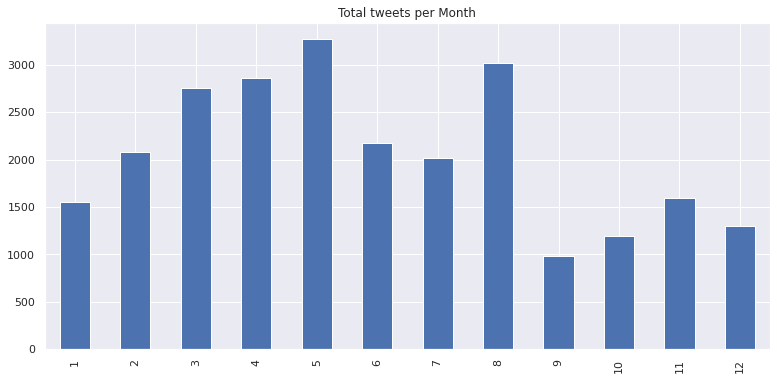

In [20]:
(tweets_df["created_at"]
 .dt.month
 .value_counts()
 .sort_index(ascending=True)
 .plot.bar(title="Total tweets per Month"));

In [21]:
# Descriptive Statistics: Tweet metrics
(tweets_df
 [["like_count", "quote_count", "reply_count", "retweet_count"]]
 .describe(percentiles=[x/100 for x in range(0,100,10)]))

,like_count,quote_count,reply_count,retweet_count
count,24808.000000,24808.000000,24808.000000,24808.000000
mean,2.751129,0.093841,0.389108,0.616978
std,15.421433,1.210027,3.742707,3.935960
min,0.000000,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000,0.000000
10%,0.000000,0.000000,0.000000,0.000000
20%,0.000000,0.000000,0.000000,0.000000
30%,0.000000,0.000000,0.000000,0.000000
40%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000


**Conclusions**

Most of the tweets have **low to none impression** to community (likes, quotes, replies, retweets). But there are few tweets that are influencials and they attract the vast majority of community's attention.

In [22]:
# What's the minimum minute for every hour.
# If the minute is too high, we can conclude that there are many tweets this hour.

## WordCloud

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [24]:
# WordCloud?

In [25]:
# Concatanate tweets on a single string
text = " ".join(review for review in tweets_df["text"])
total_words = len(text)
print (f"There are {total_words} words in the combination of all tweets.")

# Lower case the words
text = text.lower()

unique_words = set(text)
total_unique_words = len(unique_words)
print (f"The unique words are {total_unique_words}")

There are 4918284 words in the combination of all tweets.
The unique words are 665


In [26]:
# unique_words

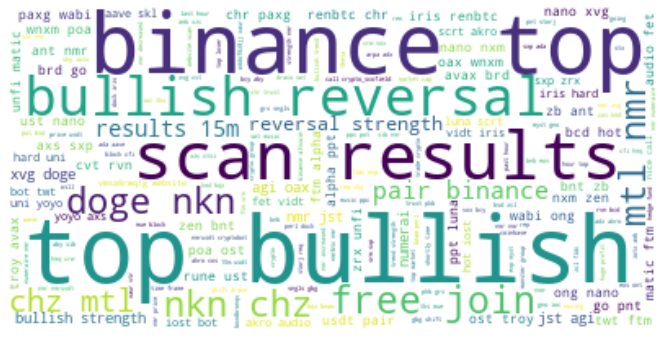

In [27]:
# Create stopword list and update it with other common words
stopwords = set(STOPWORDS)
stopwords.update(["ethereum","ether","eth", "bitcoin","btc",
                  "https","t", "u", "b s", "m", "gt","co",
                  "s","amp"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
# Most common words
wordcloud.words_

{'top bullish': 1.0,
 'binance top': 0.808130081300813,
 'scan results': 0.5031358885017422,
 'bullish reversal': 0.4994192799070848,
 'free join': 0.4882694541231127,
 'mtl nmr': 0.4367015098722416,
 'doge nkn': 0.43159117305458766,
 'nkn chz': 0.4313588850174216,
 'chz mtl': 0.4313588850174216,
 'pair binance': 0.40720092915214867,
 'results 15m': 0.40487804878048783,
 'reversal strength': 0.40371660859465736,
 'bullish strength': 0.3716608594657375,
 'xvg doge': 0.3619047619047619,
 'nmr jst': 0.3588850174216028,
 'jst agi': 0.35609756097560974,
 'agi oax': 0.35609756097560974,
 'numerai': 0.34796747967479674,
 'axs sxp': 0.2980255516840883,
 'chr paxg': 0.29523809523809524,
 'nano xvg': 0.29523809523809524,
 'iris renbtc': 0.29454123112659697,
 'renbtc chr': 0.29454123112659697,
 'paxg wabi': 0.29454123112659697,
 'wabi ong': 0.29454123112659697,
 'ong nano': 0.29454123112659697,
 'ant nmr': 0.2929152148664344,
 'usdt pair': 0.2926829268292683,
 'rune ust': 0.28408826945412313,
 'u

In [29]:
# from plotly_wordcloud import plotly_wordcloud as pwc
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)
# iplot(pwc(text))

## Find Influencers

In [ ]:
# "like_count", "quote_count", "reply_count", "retweet_count"
tweets_df.sort_values("like_count", ascending=False).head(5)

* There are plenty of popular tweets, which doesn't belong to colleted accounts in `twitter_accounts.txt` dataset.
* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

In [ ]:
# Filter tweets with low impression (without likes, retweets, retweets, replies)
threshold = 1_000
var = "like_count"

influencial_tweets_df = tweets_df.query(f" {var} > {threshold}")
print(f"There are {len(influencial_tweets_df)} tweets with more than {threshold} {var}")

In [ ]:
fig = px.line(influencial_tweets_df,
              x="created_at", y="like_count",
              title='Total likes for influencial tweets',
              hover_name="author_id", # username
              hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

# NLP

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

In [31]:
## Text preprocesing

# 1. lower_case
tweets_df['text'] = tweets_df['text'].str.lower()

## VADER

**Sentiment Analysis using VADER**

https://github.com/cjhutto/vaderSentiment

**`VADER` (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don't hold us liable).

The **`compound score`** is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between **-1 (most extreme negative) and +1 (most extreme positive)**. This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to **set standardized thresholds** for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* **positive sentiment**: `compound score >= 0.05`
* **neutral sentiment**: `(compound score > -0.05) and (compound score < 0.05)`
* **negative sentiment**: `compound score <= -0.05`

NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

In [32]:
## // DEV: Experiment with VADER //

## Extract a sentense
sentence = (tweets_df
            .sort_values("like_count", ascending=False)
            .iloc[2]["text"])

print(sentence)

## VADER
sid_obj = SentimentIntensityAnalyzer()
sentiment_dict = sid_obj.polarity_scores(sentence)
print("Overall sentiment dictionary is : ", sentiment_dict)
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")

here's my conversation with richard craib (@richardcraib) about wallstreetbets, @numerai and the future of crowdsourced, ai-assisted stock trading. https://t.co/f3dvc4j014 https://t.co/dwk5wjhdrg
Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive


In [33]:
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour
0,1141208687001780225,2021-08-30 23:46:47+00:00,1432490010046078977,$nmr\n🔻 decreased 4.34% in 9.8 hour(s)\n💵 pric...,0,0,0,0,2021-08-30,2021-08-30 23
1,1150271775273619456,2021-08-30 23:41:40+00:00,1432488721979527169,$bnt $crv $nmr $ogn $rep $req $cvc $mln keep a...,3,0,1,0,2021-08-30,2021-08-30 23
2,23025079,2021-08-30 23:21:26+00:00,1432483630341820421,$coti added some 33s 💁‍♂️🙈\n$btc $eth $mkr $aa...,4,1,14,1,2021-08-30,2021-08-30 23
3,1329640297760911361,2021-08-30 23:09:30+00:00,1432480627274629130,no monster no gain!\n\nmarket analysis &amp; r...,0,0,0,0,2021-08-30,2021-08-30 23
4,2896209087,2021-08-30 22:52:57+00:00,1432476464742608906,$nmr decision time is coming soon. i see two p...,3,0,1,0,2021-08-30,2021-08-30 22


In [34]:
# import swifter

Note that `swifter` will not work automatically for **string columns**. When using strings, Swifter will fallback to a “simple” Pandas apply, which will not be parallel. In this case, even forcing it to use dask will not create performance improvements, and you would be better off just splitting your dataset manually and parallelizing using multiprocessing.

In [35]:
## Calculate sentiment for each tweet

def extract_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict["compound"]

# Extract a sample of tweets
# tweets_df = tweets_df.sample(1000)
# tweets_df = tweets_df[:10_000]

tweets_df['sentiment'] = (tweets_df['text']
                          # .swifter.apply(lambda x: extract_sentiment(x))
                          .progress_apply(lambda x: extract_sentiment(x))
                         )

100%|██████████| 24808/24808 [03:15<00:00, 126.99it/s]


In [36]:
## Work-around: Create a random sentiment column
# tweets_df['sentiment'] = np.random.uniform(low=-1,high=1, size=len(tweets_df))

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
# Most positive tweets
positive_tweets_df = (tweets_df
                      .sort_values("sentiment", ascending=False)
                      .head(5)
                      .sort_values("created_at")
                      [["author_id", "created_at", "text", "sentiment"]])
positive_tweets_df

,author_id,created_at,text,sentiment
19251,1255850985546604544,2020-08-31 03:24:21+00:00,a friendly reminder that the 9 new #enceladus #ampleforth geysers are still online and ready for staking!\n\n$ampl 🪐🌓🌊🌊🌊\n\n✨✨✨✨✨\n\n$bal\n$bzrx\n$comp\n$crv\n$link\n$mkr\n$nmr\n$yfi\n$ycrv\n\n✨✨✨✨✨ https://t.co/3qwnqltjdp,0.9750
15645,1302032140163522560,2020-11-28 17:37:46+00:00,nmr / btc\ncup-handle formation has been created for the #nmrbtc. maybe it can retest at 2081 sats. but i hope it reaches its targets on the #chart below. best wins.🙏\n\n#nmr #nmrbtc #nmrusdt $nmr #btc #btcusd $eth #ethereum #ethbtc #crypto #bitcoin #freedom $ocean https://t.co/azyljc0wly,0.9758
11817,714183943327760385,2021-02-16 03:17:46+00:00,$nmr is legit the best tehe i think that it's great along with $btc and $eth is legit the best tehe i think that it's great along with is legit the best tehe i think that it's great along with is legit the best tehe i think that it's great along with,0.9884
8678,830101164737847296,2021-04-04 00:09:31+00:00,"honestly grateful every day for the @numerai community. \n\ni've learned so much about how blockchains work, went from 0 coding to machine learning, and scored the best hat from @tasha_jade.\n\ni haven't been super active lately, but i love you all ♥️♥️♥️ #numeraiordie",0.9836
2144,609513459,2021-07-14 16:50:22+00:00,"crypto twitter has made twitter for me. i've had an account since 2012 but i haven't used it until this year. fuckin' great mate 😎 $ksm $dot $link $nmr $xtz $eth $btc $rmrk $kar $xrt $bnc $sdn and yes, $doge\n\n#crypto #bitcoin #blockchain #decentralization #freedom",0.9714


In [41]:
# Most negative tweets
negative_tweets_df = (tweets_df
                      .sort_values("sentiment")
                      .head(5)
                      .sort_values("created_at")
                      [["author_id","created_at", "text", "sentiment"]])
negative_tweets_df

,author_id,created_at,text,sentiment
12182,947953619726360576,2021-02-10 18:00:14+00:00,📈 biggest gainers (1 hr) 📈\nnumeraire $nmr 25.81% 🔥🔥🔥\nmatic network $matic 19.37% 🔥🔥🔥\nserum $srm 18.34% 🔥🔥🔥\nreserve rights $rsr 17.57% 🔥🔥🔥\nbalancer $bal 14.43% 🔥🔥,-0.9810
11394,947953619726360576,2021-02-23 14:00:16+00:00,📈 biggest gainers (1 hr) 📈\nnumeraire $nmr 27.22% 🔥🔥🔥\ntheta fuel $tfuel 26.85% 🔥🔥🔥\ntomochain $tomo 23.04% 🔥🔥🔥\npolkastarter $pols 20.66% 🔥🔥🔥\nserum $srm 20.63% 🔥🔥🔥,-0.9834
4839,947953619726360576,2021-05-29 17:00:04+00:00,📈 biggest gainers (1 hr) 📈\nhorizen $zen 10.88% 🔥🔥🔥\nnumeraire $nmr 7.71% 🔥🔥🔥\nthorchain $rune 7.32% 🔥🔥🔥\narweave $ar 6.61% 🔥🔥\nwazirx $wrx 5.41% 🔥🔥,-0.9781
4410,947953619726360576,2021-06-03 01:00:31+00:00,📈 biggest gainers (1 hr) 📈\nnervos network $ckb 15.48% 🔥🔥🔥\nnumeraire $nmr 7.63% 🔥🔥🔥\nneo $neo 6.64% 🔥🔥\nabbc coin $abbc 6.22% 🔥🔥\nontology gas $ong 5.77% 🔥🔥,-0.9744
1662,1365817266013679628,2021-07-25 03:11:58+00:00,this $nmr can go anywhere 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥\n\nhot and on fire 🔥🔥🔥🔥🔥\n\n#cryptotrade #cryptocurency #cryptoworld #cryptonews #crypto #cryptotrading $btc $eth,-0.9906


## Plots

In [ ]:
# Extract most positive and most negative tweets and plot them
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=negative_tweets_df["created_at"],
                         y=negative_tweets_df["sentiment"],
                         mode='lines+markers',
                         text=negative_tweets_df['text'],
                         hovertemplate="<p>%{text}</p>",
                         name='Most Negative tweets',
                         line=dict(color='red')))

fig.add_trace(go.Scatter(x=positive_tweets_df["created_at"],
                         y=positive_tweets_df["sentiment"],
                         mode='lines+markers',
                         name='Most Positive tweets',
                         line=dict(color='green')))


fig.show()

In [ ]:
# Γράφημα stacked bar plot για κάθε ημέρα πόσο είναι θετικό, πόσο αρνητικό, πόσο neutral
tweets_df["sentiment_val"] = pd.cut(tweets_df["sentiment"], bins = [-1, -0.05, 0.05, 1],
                                    labels=['negative', 'neutral', 'positive'])

sentiment_proportions = (tweets_df
                         .groupby("created_at_date_hour")
                         ["sentiment_val"]
                         .value_counts(normalize=True)
                         .to_frame())

sentiment_proportions = sentiment_proportions.rename(columns={"sentiment_val":"sentiment_proportions"})
sentiment_proportions = sentiment_proportions.reset_index()

In [ ]:
sentiment_proportions.head(6)

In [ ]:
fig = px.bar(sentiment_proportions[:3*22],
             x="created_at_date_hour",
             y="sentiment_proportions", color="sentiment_val",
             title="Proportion of sentiment per day",
            color_discrete_sequence=["lightgreen", "royalblue", "red"])

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='positive'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='positive'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Positive tweets',
                         line=dict(color='lightgreen')))

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='neutral'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='neutral'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Neutral tweets',
                         line=dict(color='royalblue')))


fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='negative'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='negative'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Negative tweets',
                         line=dict(color='red')))

fig.update_layout(title='Proportion of sentiment in tweets',
                   xaxis_title='Date',
                   yaxis_title='Proportion')

fig.show()

# Store Final Dataset

In [42]:
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour,sentiment
0,1141208687001780225,2021-08-30 23:46:47+00:00,1432490010046078977,$nmr\n🔻 decreased 4.34% in 9.8 hour(s)\n💵 price - 42.81000000 usdt\n⏱️ [30 aug] - 23:46:47 utc\n#nmr #nmrusdt #cryptobot,0,0,0,0,2021-08-30,2021-08-30 23,0.0000
1,1150271775273619456,2021-08-30 23:41:40+00:00,1432488721979527169,$bnt $crv $nmr $ogn $rep $req $cvc $mln keep an eye out for these coins exploding soon as i have a feeling 🙏🏽,3,0,1,0,2021-08-30,2021-08-30 23,0.1280
2,23025079,2021-08-30 23:21:26+00:00,1432483630341820421,$coti added some 33s 💁‍♂️🙈\n$btc $eth $mkr $aave $comp $uni $link $xrp $doge $icp $ect $snx $sol $mln $qnt $farm $yfi $forth $storj $fil $mana $enj $ogn $bal $nmr $fet $ach $amp $ankr $zrx $req $iotx $nu $lrc $ren $grt $matic $crv $luna $wluna $crv $dnt $cvc $uma $rep $quick https://t.co/nkrlhxlny2,4,1,14,1,2021-08-30,2021-08-30 23,0.0000
3,1329640297760911361,2021-08-30 23:09:30+00:00,1432480627274629130,"no monster no gain!\n\nmarket analysis &amp; recaps, scalping leverage calls, binance altcoin signals and real time news.\n\nfree join : https://t.co/hp22zvjnm6\n\n$arpa $adx $akro $cos $kmd $bqx $beam $perl $dock $iris $renbtc $chr $paxg $wabi $ong $nano $xvg $doge $nkn $chz $mtl $nmr",0,0,0,0,2021-08-30,2021-08-30 23,0.4027
4,2896209087,2021-08-30 22:52:57+00:00,1432476464742608906,$nmr decision time is coming soon. i see two possible directions: either it pumps to 50+ within the week or it breaks this trendline and dumps to support. https://t.co/dmffnn1ipz,3,0,1,0,2021-08-30,2021-08-30 22,0.0000


In [43]:
# Store the final dataset (Try parquet)
# tweets_df.to_pickle("../data/tweets_df_sentiment.pkl")
tweets_df.to_pickle("../data/numerai_tweets_df_sentiment.pkl")